In [262]:
import pandas as pd
import numpy as np
import random
import scipy.sparse as sp
from scipy.sparse.linalg import svds
import math
from sklearn.cross_validation import KFold
import time
import matplotlib.pyplot as plt

In [327]:
rm = pd.DataFrame.from_csv("rating_matrix.csv")
um = pd.DataFrame.from_csv("user_avg.csv")

In [328]:
def count_not_null(df):
    count = 0
    for i in df.index:
        for j in df.columns:
            if not pd.isnull(df[j][i]):
                count += 1
    return count

In [233]:
print("rating matrix size: " +  str(rm.size))
print("non-null rating: " +  str(count_not_null(rm)))
print(str(round(count_not_null(rm) * 100 /rm.size, 2)) + "% valid rating")

rating matrix size: 387300
non-null rating: 17651
4.56% valid rating


# Model-Based - SVD

## I.  5-fold cross-validation with Scipy SVD 

Modeling with rating matrix size of 3873 x 100

In [329]:
#split non-empty pairs data into 80% train and 20% test sets
test=[]
train=[]
random.seed(10)
for j in rm:
    for i in rm.index:
        r=random.random()
        if not pd.isnull(rm[j][i]):
            if r<=0.8:
                train.append([j,i,rm[j][i]])
            else:
                test.append([j,i,rm[j][i]])

First, we try to fill missing values with user's average rating provided by Yelp. If there is no average rating for a user, then calculate it from the rating matrix.

In [330]:
def SVD_5_fold_cross_validation(train, test, rating_matrix, UM):
    rm = rating_matrix.copy()
    K_svd = [3,5,10,15,20,25,30]
    kf = KFold(len(train), n_folds=5, shuffle=True)
    partition = []
    for iteration, data in enumerate(kf, start=1):
        partition.append(data[1])
        
    for item in test:
        rm[item[0]][item[1]] = None      # fill test set values with na
            
    K_svd_RMSE = []
    for k in K_svd:
        RMSE = []
        for tune in partition: # Each fold as a test set
            rm_sub = rm.copy()
            for idx in tune:
                rm_sub[train[idx][0]][train[idx][1]] = None
            
            A = rm_sub.copy()
            
            for i in A.columns:
                for j in A.index:
                    if pd.isnull(A[i][j]):
                        if j in UM.index:
                            A[i][j] = UM['user_mean'][j]           # fill na with user mean
                        else:
                            A[i][j] = rating_matrix.loc[j].mean()  # or calculate row mean if no public user profile
            R = A.as_matrix()
            U, sigma, Vt = svds(R, k = k)
            sigma = np.diag(sigma)
            all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
            preds_df = pd.DataFrame(all_user_predicted_ratings, columns = A.columns, index = A.index)
                                  
            
            SUM=0
            COUNT=0
            for i in tune:
                x = train[i][1]
                y = train[i][0]
                value = train[i][2]
                SUM +=(value - preds_df[y][x])**2
                COUNT+=1
            rmse = math.sqrt(SUM/COUNT)
            RMSE.append(rmse)
            
        K_svd_RMSE.append([k,np.mean(RMSE)])

    return  K_svd_RMSE

In [84]:
result = SVD_5_fold_cross_validation(train, test, rm, um)

In [85]:
result

[[3, 0.98809685103283429],
 [5, 0.98828261491782377],
 [10, 0.98834071915448862],
 [15, 0.9891772993038821],
 [20, 0.98977558732861548],
 [25, 0.99109471849802377],
 [30, 0.99162267352962608]]

Then, we try to fill missing value with rating matrix row mean for each user.

In [331]:
def SVD_5_fold_cross_validation_2(train, test, rating_matrix, UM):
    rm = rating_matrix.copy()
    K_svd = [3,5,10,15,20,25,30]
    kf = KFold(len(train), n_folds=5, shuffle=True)
    partition = []
    for iteration, data in enumerate(kf, start=1):
        partition.append(data[1])
        
    for item in test:
        rm[item[0]][item[1]] = None      # fill test set values with na
            
    K_svd_RMSE = []
    for k in K_svd:
        RMSE = []
        for tune in partition: # Each fold as a test set
            rm_sub = rm.copy()
            for idx in tune:
                rm_sub[train[idx][0]][train[idx][1]] = None
            
            A = rm_sub.copy()
            
            for i in A.columns:
                for j in A.index:
                    if pd.isnull(A[i][j]):
                        A[i][j] = rating_matrix.loc[j].mean()  # or calculate row mean if no public user profile
            R = A.as_matrix()
            U, sigma, Vt = svds(R, k = k)
            sigma = np.diag(sigma)
            all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
            preds_df = pd.DataFrame(all_user_predicted_ratings, columns = A.columns, index = A.index)
                                  
            
            SUM=0
            COUNT=0
            for i in tune:
                x = train[i][1]
                y = train[i][0]
                value = train[i][2]
                SUM +=(value - preds_df[y][x])**2
                COUNT+=1
            rmse = math.sqrt(SUM/COUNT)
            RMSE.append(rmse)
            
        K_svd_RMSE.append([k,np.mean(RMSE)])

    return  K_svd_RMSE

In [88]:
result2 = SVD_5_fold_cross_validation_2(train, test, rm, um)

The result shows that fill missnig value with row mean has a better performance, so we will stick with it.

In [89]:
result2

[[3, 0.86713915739833514],
 [5, 0.86585141327749005],
 [10, 0.86361151229424726],
 [15, 0.86457206268291298],
 [20, 0.86505335539881512],
 [25, 0.86583187401268202],
 [30, 0.86492348069522562]]

In [102]:
y = []
x = [3,5,10,15,20,25,30]
for i in result2:
    y.append(i[1])

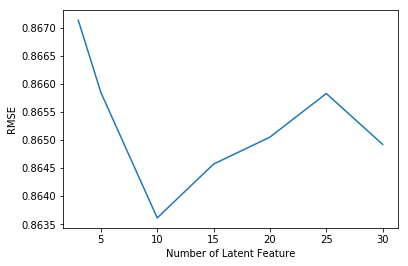

In [104]:
import matplotlib.pyplot as plt
plt.plot(x, y)
plt.ylabel('RMSE')
plt.xlabel('Number of Latent Feature')
plt.show()

### Test Set RMSE

Use k = 10 for the test set.

In [257]:
start_time = time.time()
for idx in test:
    rm_sub[idx[0]][idx[1]] = None
            
A = rm_sub.copy()
            
for i in A.columns:
    for j in A.index:
        if pd.isnull(A[i][j]):
            A[i][j] = rm.loc[j].mean()  
R = A.as_matrix()
U, sigma, Vt = svds(R, k = 10)
sigma = np.diag(sigma)
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = A.columns, index = A.index)
                                  
SUM=0
COUNT=0
for i in test:
    x = i[1]
    y = i[0]
    value = i[2]
    SUM +=(value - preds_df[y][x])**2
    COUNT+=1
rmse = math.sqrt(SUM/COUNT)
print(rmse)
end_time = time.time()
print("time elapsed: " + str(end_time - start_time))

0.8698609691586622
time elapsed: 153.60882997512817


### SVD - Coverage Test

In [208]:
def SVD_data_set_size(train, test, rating_matrix, UM):
    A = rating_matrix.copy()
    
    kf = KFold(len(train), n_folds=5, shuffle=True)
    partition = []

    for item in test:
        A[item[0]][item[1]] = None
       
    for i in A.columns:
        for j in A.index:
            if pd.isnull(A[i][j]):

                A[i][j] = rating_matrix.loc[j].mean()
    
    R = A.as_matrix()
    U, sigma, Vt = svds(R, k = 10)
    sigma = np.diag(sigma)
    all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
    preds_df = pd.DataFrame(all_user_predicted_ratings, columns = A.columns, index = A.index)
                                  
    SUM=0
    COUNT=0
    for i in test:
        SUM +=(i[2] - preds_df[i[0]][i[1]])**2
        COUNT+=1
    RMSE = math.sqrt(SUM/COUNT)
    print(RMSE)

    return  RMSE

In [210]:
def data_set_partition(original_data):
    test=[]
    train=[]
    for j in original_data.columns:
        for i in original_data.index:
            r=random.random()
            if not pd.isnull(original_data[j][i]):
                if r<=0.8:
                    train.append([j,i,original_data[j][i]])
                else:
                    test.append([j,i,original_data[j][i]])
                    
    return [train, test]

In [310]:
rm95 = pd.DataFrame.from_csv("rm95.csv")
um95 = pd.DataFrame.from_csv("um95.csv")
rm105 = pd.DataFrame.from_csv("rm105.csv")
um105 = pd.DataFrame.from_csv("um105.csv")
rm115 = pd.DataFrame.from_csv("rm115.csv")
um115 = pd.DataFrame.from_csv("um115.csv")
rm125 = pd.DataFrame.from_csv("rm125.csv")
um125 = pd.DataFrame.from_csv("um125.csv")

In [235]:
print("rating matrix size: " +  str(rm95.size))
print("non-null rating: " +  str(count_not_null(rm95)))
print(str(round(count_not_null(rm95) * 100 /rm95.size, 2)) + "% valid rating")
print('----------------------------------------------------------')
print("rating matrix size: " +  str(rm105.size))
print("non-null rating: " +  str(count_not_null(rm105)))
print(str(round(count_not_null(rm105) * 100 /rm105.size, 2)) + "% valid rating")
print('----------------------------------------------------------')
print("rating matrix size: " +  str(rm115.size))
print("non-null rating: " +  str(count_not_null(rm115)))
print(str(round(count_not_null(rm115) * 100 /rm115.size, 2)) + "% valid rating")
print('----------------------------------------------------------')
print("rating matrix size: " +  str(rm125.size))
print("non-null rating: " +  str(count_not_null(rm125)))
print(str(round(count_not_null(rm125) * 100 /rm125.size, 2)) + "% valid rating")

rating matrix size: 848598
non-null rating: 24430
2.88% valid rating
----------------------------------------------------------
rating matrix size: 722455
non-null rating: 22872
3.17% valid rating
----------------------------------------------------------
rating matrix size: 595620
non-null rating: 21176
3.56% valid rating
----------------------------------------------------------
rating matrix size: 498491
non-null rating: 19679
3.95% valid rating


In [218]:
def batch_run(rm, um):
    data1 = data_set_partition(rm)
    result1  = SVD_data_set_size(data1[0], data1[1], rm, um)
    data2 = data_set_partition(rm)
    result2  = SVD_data_set_size(data2[0], data2[1], rm, um)
    data3 = data_set_partition(rm)
    result3  = SVD_data_set_size(data3[0], data3[1], rm, um)
    data4 = data_set_partition(rm)
    result4  = SVD_data_set_size(data4[0], data4[1], rm, um)
    data5 = data_set_partition(rm)
    result5  = SVD_data_set_size(data5[0], data5[1], rm, um)
    avg = (result1 + result2 + result3 + result4 + result5)/5
    return avg

In [219]:
result95 = batch_run(rm95, um95)
result105 = batch_run(rm105, um105)
result115 = batch_run(rm115, um115)
result125 = batch_run(rm125, um125)

0.8747963095301636
0.8690348155097669
0.8719536633410668
0.8764020204541613
0.8761249474693688
0.8804017664864292
0.8991626867437207
0.8894410738333025
0.8632399680114888
0.8797068772479869
0.8584538282585363
0.8641884609265342
0.8780295150474747
0.8673425537406237
0.8892000202879727
0.8611425549132181
0.8698724607070463
0.8487520674854
0.8629666795653732
0.8865913287202742


In [244]:
test_result

[0.8709590930164416,
 0.8658650182782625,
 0.8714428756522283,
 0.8823904744645856,
 0.8736623512609055]

In [311]:
data = data_set_partition(rm95)
start95 = time.time()
SVD_data_set_size(data[0], data[1], rm95, um95)
end95 = time.time()
RT95 = end95 - start95

data = data_set_partition(rm105)
start105 = time.time()
SVD_data_set_size(data[0], data[1], rm105, um105)
end105 = time.time()
RT105 = end105 - start105

data = data_set_partition(rm115)
start115 = time.time()
SVD_data_set_size(data[0], data[1], rm115, um115)
end115 = time.time()
RT115 = end115 - start115

data = data_set_partition(rm125)
start125 = time.time()
SVD_data_set_size(data[0], data[1], rm125, um125)
end125 = time.time()
RT125 = end125 - start125

0.8927587170794206
0.8758602074886365
0.8734680070680882
0.875646998004387


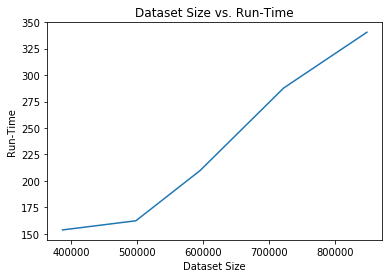

In [315]:
RT = [153.608, RT125, RT115, RT105, RT95]
size = [rm.size, rm125.size, rm115.size, rm105.size, rm95.size]
plt.plot(size, RT)
plt.ylabel('Run-Time')
plt.xlabel('Dataset Size')
plt.title('Dataset Size vs. Run-Time')
plt.show()

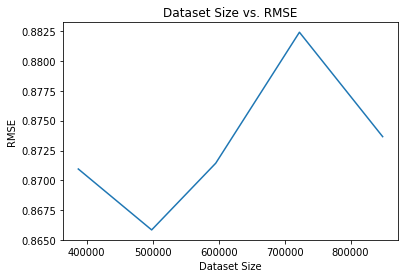

In [228]:
test_result = [rmse, result125, result115, result105, result95]
size = [rm.size, rm125.size, rm115.size, rm105.size, rm95.size]
plt.plot(size, test_result)
plt.ylabel('RMSE')
plt.xlabel('Dataset Size')
plt.title('Dataset Size vs. RMSE')
plt.show()

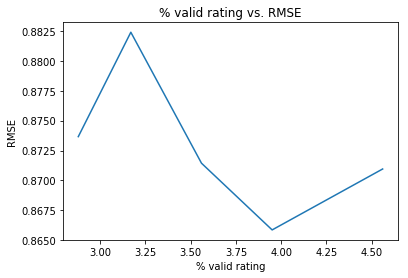

In [236]:
test_result = [rmse, result125, result115, result105, result95]
valid_rating = [4.56, 3.95, 3.56, 3.17, 2.88]
import matplotlib.pyplot as plt
plt.plot(valid_rating, test_result)
plt.ylabel('RMSE')
plt.xlabel('% valid rating')
plt.title('% valid rating vs. RMSE')
plt.show()

## II. Stochastic Gradient Descent

In [242]:
def SGD(matrix, K, steps=400, gama=0.02, lamda=0.01):  
    slowRate = 0.99  
    preRmse = 1000000000.0  
    nowRmse = 0.0  
  
    user_feature = np.matrix(np.random.rand(matrix.shape[0], K))  
    item_feature = np.matrix(np.random.rand(matrix.shape[1], K))  
  
    for step in range(steps):  
        rmse = 0.0    
        n = 0    
        for u in range(matrix.shape[0]):  
            for i in range(matrix.shape[1]):  
                if not np.isnan(matrix[u,i]):  
                    Uui = float(np.dot(user_feature[u,:], item_feature[i,:].T))  
                    eui = matrix[u,i] - Uui  
                    rmse += pow(eui, 2)  
                    n += 1   
                    for k in range(K):  
                        user_feature[u,k] += gama*(eui*item_feature[i,k] - lamda*user_feature[u,k])  
                        item_feature[i,k] += gama*(eui*user_feature[u,k] - lamda*item_feature[i,k])   
  
        nowRmse = pow((rmse * 1.0 / n) , 0.5)
#        print ('step: %d      Rmse: %s' % ((step+1), nowRmse)  )
        if (nowRmse < preRmse):    
            preRmse = nowRmse  
        else:  
            break 
        gama *= slowRate  
        step += 1  
  
    return user_feature, item_feature  

In [264]:
rm = pd.DataFrame.from_csv("rating_matrix.csv")
um = pd.DataFrame.from_csv("user_avg.csv")

test=[]
train=[]
tune = []
random.seed(10)
for j in rm:
    for i in rm.index:
        if not pd.isnull(rm[j][i]):
            r=random.random()
            if r <=0.6:
                train.append([j,i,rm[j][i]])
            elif r > 0.8:
                test.append([j,i,rm[j][i]])
            else:
                tune.append([j,i,rm[j][i]])

In [265]:
rating = rm.copy()
for i in tune:
    rating[i[0]][i[1]] = None

for i in test:
    rating[i[0]][i[1]] = None
                
R = rating.as_matrix()
K_Value = [5,8,10,12,15,20,25,30]
Result = []
for k in K_Value:
    U, V = SGD(R, k, steps= 400, gama=0.02, lamda= 0.3) 
    all_user_predicted_ratings = np.dot(U, V.T) 
    preds_df = pd.DataFrame(all_user_predicted_ratings, columns = rating.columns, index = rating.index)
                                      
    SUM=0
    COUNT=0
    for i in tune:
        x = i[1]
        y = i[0]
        value = i[2]
        SUM +=(value - preds_df[y][x])**2
        COUNT+=1

    rmse = math.sqrt(SUM/COUNT)
    print([k,rmse])
    Result.append([k,rmse])

[5, 1.3153089512179927]
[8, 1.2392235791252173]
[10, 1.20105869967384]
[12, 1.1830996494620896]
[15, 1.1672580180519743]
[20, 1.153142162417225]
[25, 1.1715074066048363]
[30, 1.2008330681590655]


In [266]:
rating = rm.copy()
for i in tune:
    rating[i[0]][i[1]] = None

for i in test:
    rating[i[0]][i[1]] = None
                
R = rating.as_matrix()
K_Value = [20]
Result2 = []
for k in K_Value:
    U, V = SGD(R, k, steps= 400, gama=0.02, lamda= 0.005) 
    all_user_predicted_ratings = np.dot(U, V.T) 
    preds_df = pd.DataFrame(all_user_predicted_ratings, columns = rating.columns, index = rating.index)
                                      
    SUM=0
    COUNT=0
    for i in tune:
        x = i[1]
        y = i[0]
        value = i[2]
        SUM +=(value - preds_df[y][x])**2
        COUNT+=1

    rmse = math.sqrt(SUM/COUNT)
    print([k,rmse])
    Result2.append([k,rmse])

[20, 1.2484142412857955]


In [269]:
Result

[[5, 1.3153089512179927],
 [8, 1.2392235791252173],
 [10, 1.20105869967384],
 [12, 1.1830996494620896],
 [15, 1.1672580180519743],
 [20, 1.153142162417225],
 [25, 1.1715074066048363],
 [30, 1.2008330681590655]]

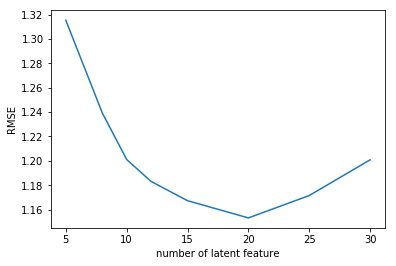

In [270]:
test_result = [Result[0][1],Result[1][1], Result[2][1],Result[3][1],Result[4][1], Result[5][1],Result[6][1],Result[7][1]]
feature = [Result[0][0],Result[1][0], Result[2][0],Result[3][0],Result[4][0], Result[5][0],Result[6][0],Result[7][0]]
plt.plot(feature, test_result)
plt.ylabel('RMSE')
plt.xlabel('number of latent feature')
plt.show()

### Test Set SGD

In [271]:
rating = rm.copy()
start_time = time.time()
for i in test:
    rating[i[0]][i[1]] = None
                
R = rating.as_matrix()
K_Value = [20]
Result_test = []
for k in K_Value:
    U, V = SGD(R, k, steps= 400, gama=0.02, lamda= 0.3) 
    all_user_predicted_ratings = np.dot(U, V.T) 
    preds_df = pd.DataFrame(all_user_predicted_ratings, columns = rating.columns, index = rating.index)
                                      
    SUM=0
    COUNT=0
    for i in test:
        x = i[1]
        y = i[0]
        value = i[2]
        SUM +=(value - preds_df[y][x])**2
        COUNT+=1

    rmse = math.sqrt(SUM/COUNT)
    print([k,rmse])
    Result_test.append([k,rmse])
end_time = time.time()
print("time elapsed: " + str(end_time - start_time))

[20, 1.139885524681472]
time elapsed: 1355.336797952652


### Adding user/item bias terms to SGD

In [302]:
def SGD_bias(matrix, K, steps=400, gama=0.02, lamda=0.01):  
    slowRate = 0.99  
    preRmse = 1000000000.0  
    nowRmse = 0.0  
  
    user_feature = np.matrix(np.random.rand(matrix.shape[0], K+2))  
    for i in range(user_feature.shape[0]):
        user_feature[i, K+1] = 1
    
    item_feature = np.matrix(np.random.rand(matrix.shape[1], K+2))  
    for i in range(item_feature.shape[0]):
        item_feature[i, K] = 1
  
    for step in range(steps):  
        rmse = 0.0    
        n = 0    
        for u in range(matrix.shape[0]):  
            for i in range(matrix.shape[1]):  
                if not np.isnan(matrix[u,i]):  
                    Uui = float(np.dot(user_feature[u,:], item_feature[i,:].T))  
                    eui = matrix[u,i] - Uui  
                    rmse += pow(eui, 2)  
                    n += 1   
                    for k in range(K+2):  
                        user_feature[u,k] += gama*(eui*item_feature[i,k] - lamda*user_feature[u,k])  
                        item_feature[i,k] += gama*(eui*user_feature[u,k] - lamda*item_feature[i,k])  
                    
                    for i in range(user_feature.shape[0]):
                        user_feature[i, K+1] = 1
                                          
                    for i in range(item_feature.shape[0]):
                        item_feature[i, K] = 1
  
        nowRmse = pow((rmse * 1.0 / n) , 0.5)
#        print ('step: %d      Rmse: %s' % ((step+1), nowRmse)  )
        if (nowRmse < preRmse):    
            preRmse = nowRmse  
        else:  
            break 
        gama *= slowRate  
        step += 1  
  
    return user_feature, item_feature  

In [316]:
rating = rm.copy()
for i in tune:
    rating[i[0]][i[1]] = None

for i in test:
    rating[i[0]][i[1]] = None
                
R = rating.as_matrix()
K_Value = [14,16]
Result3 = []
#start_sgd_bias = time.time()
for k in K_Value:
    U, V = SGD_bias(R, k, steps= 400, gama=0.02, lamda= 0.3) 
    all_user_predicted_ratings = np.dot(U, V.T) 
    preds_df = pd.DataFrame(all_user_predicted_ratings, columns = rating.columns, index = rating.index)
                                      
    SUM=0
    COUNT=0
    for i in tune:
        x = i[1]
        y = i[0]
        value = i[2]
        SUM +=(value - preds_df[y][x])**2
        COUNT+=1

    rmse = math.sqrt(SUM/COUNT)
    print([k,rmse])
    Result3.append([k,rmse])
#end_sgd_bias = time.time()

[14, 1.1392910086276204]
[16, 1.1372724811286536]


In [317]:
sgd_bias_result = [[5, 1.1961627771022152],
[8, 1.1659720846064754],
[14, 1.1392910086276204],
[15, 1.1376715668986543],
[16, 1.1372724811286536],
[20, 1.1403503959607277]]

run-time

In [309]:
one_run = (end_sgd_bias - start_sgd_bias)/2
one_run

4610.575373530388

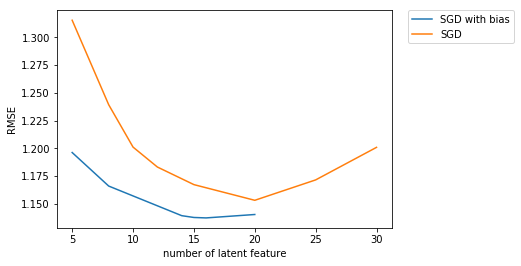

In [325]:
test_result_sgd_bias = [sgd_bias_result[0][1],sgd_bias_result[1][1], sgd_bias_result[2][1],sgd_bias_result[3][1],sgd_bias_result[4][1], sgd_bias_result[5][1]]
feature_sgd_bias = [sgd_bias_result[0][0], sgd_bias_result[1][0], sgd_bias_result[2][0],sgd_bias_result[3][0], sgd_bias_result[4][0], sgd_bias_result[5][0]]
sgd_bias_line = plt.plot(feature_sgd_bias , test_result_sgd_bias, label = 'SGD with bias')
sgd_line = plt.plot(feature, test_result, label = 'SGD')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel('RMSE')
plt.xlabel('number of latent feature')
plt.show()